In [1]:
import numpy as np
import random
import pylab

import matplotlib.pyplot as plt
import copy
import matplotlib as mpl
import collections
import matplotlib
import matplotlib.animation as animation
from IPython.display import Video
import seaborn as sns

# Simulation

In [2]:
colors_dict = {'Empty': 0, 'Building': 1, 'Car': 2, 'green': 3, 'red': 4, 'orange': 5}

In [3]:
def observe(config):
    
    """
    A function to obsere the state of CA. The CA array has objects instead of numbers so this function will
    first replace each object by its CA value.
    """
    
    vectorized_x = np.vectorize(lambda obj: obj.cell_value)

    view_grid = vectorized_x(config)
    
    plt.figure(figsize = (10, 8))
    
    colors = ['white', 'gray', 'black',  'green','red' , 'blue', 'orange']
    bounds = [ 0,1,2,3,4, 5, 6]

    cmap = mpl.colors.ListedColormap(colors)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    pylab.cla()
    pylab.imshow(view_grid, interpolation='none', cmap=cmap, norm=norm)
    
class Q:
    """
    A class for the queue of cars at the stop signs to model the first arrives first leaves rule
    """
    def __init__(self):
        self.q = []
    
    
class city_block:
    """
    A class to represent the building/block areas of the city (the areas where cars can't move in).
    """
    def __init__(self):
        self.cell_value = 1
    
class city_cell:
    
    """
    A class to represent the roads of the city. Each cell can be either empty (0) or can carry
    one car (1). 
    """
    def __init__(self,  direction = None ):
        self.cell_value = 0
        self.direction = None 
        self.contains_car = False
    
    def fill_car(self, car):
        """
        To change the value of the empty cell when a car moves on it
        """
        self.contains_car = car
        self.cell_value = 2
        if not car.direction:
            car.direction = self.direction
    def empty_car(self):
        """
        To remove the car and change the cell back to empty
        """
        self.contains_car = False
        self.cell_value = 0
        

        
class traffic_light:
    """
    A class to represent the traffic lights in the city.
    Each traffic light has only two colors:
    - Red which prohibts all cars from moving.
    - Green which allows cars to move.
    """
    def __init__(self, cell_value, state):
        
        self.states = ["green", "red"]
        self.current_state = state
        self.cell_value = cell_value
        self.contains_car = False 
        
    def change(self):
        if self.current_state== 'green':
            self.current_state= 'red'
            self.cell_value = 4
        else:
            self.current_state= 'green'
            self.cell_value = 3

    def fill_car(self, car):
        self.contains_car = car
        self.cell_value = 2
    def empty_car(self):
        self.contains_car = False
        self.cell_value = colors_dict[self.current_state]
              
            
            
class stop_sign:
    """
    A class to represent the traffic stop signs that are used at the intersections. 
    """
    
    def __init__(self):
        self.cell_value = 5 
        self.contains_car = False
        self.queue = []
        
    def fill_car(self, car):
        self.contains_car = car
        self.cell_value = 2
    def empty_car(self):
        self.contains_car = False
        self.cell_value = 5
           
            
            
            
            
class Car:
    """
    A class to model the movement of cars in the city.
    """
    def __init__(self, location, speed=1):
        self.cell_value = 2
        self.speed = speed
        self.max_speed = 5
        self.location = location
        self.direction = None
        self.prob_slowdown = 0.5 # probability of random slowing down 
        self.prob_change = 0.2 # probability of changing the road at intersections
        self.inq = False # if the car is waiting in a queue at a stop sign
        self.waiting = False
        
        
        
    def get_next_cell(self, r, c, incr):
        """
        This function will be used to get the next cell of each car using the car's current cell
        and the direction
        Inputs:
        - r, c: current row and column coordinates of the car
        - incr: speed of the car (or how many cells the car increments)
        """
        crossing = False #if the car is changing direction at an intersection
        
        if self.direction ==  "North":
            next_cell = [(r-incr), c]
            
            #changing the direction of cars randomly at intersections (the middle points are intersections)
            if next_cell in middle_points and random.uniform(0, 1) <self.prob_change:
                crossing = city[(r-incr), c+3].direction
                
                
        elif self.direction ==  "South":
            next_cell =[(r+incr), c]
            if next_cell in middle_points and random.uniform(0, 1) <self.prob_change:
                crossing = city[(r+incr), c-3].direction
            
                
                
        elif self.direction ==  "East":
            next_cell =[r, (c+incr)]
            if next_cell in middle_points and random.uniform(0, 1) <self.prob_change:
                crossing = city[r+3, (c+incr)].direction
            
                
                
        elif self.direction ==  "West":
            next_cell =[r, (c-incr)]
            if next_cell in middle_points and random.uniform(0, 1) <self.prob_change:
                crossing = city[r-3, (c-incr)].direction
            
        
        return next_cell, crossing
      
    
    def move(self, city, time_step):
        
        """
        A function to move the cars to their next cell.
        Inputs:
        city: the CA grid
        time_step: the time at which the car is moving
        """
       
        current_cell=self.location
        
        if [current_cell[0], current_cell[1]] not in exits: #if the car is not at the border of the grid
            
            self.update_speed(time_step) #read the update_speed function below
            
            
            if not self.waiting: # if cars not on stop sign
                # let them move to the next cell according to their speed
                next_cell, crossing = self.get_next_cell(current_cell[0], current_cell[1], self.speed)
                if self.speed >0 :
                    
                    n1, crossing = self.get_next_cell(current_cell[0], current_cell[1], 1)
                    if city[n1[0], n1[1]].cell_value ==3:
                        n2, crossing = self.get_next_cell(current_cell[0], current_cell[1], 2)
                        n3, crossing = self.get_next_cell(current_cell[0], current_cell[1], 3)
                        if city[n2[0], n2[1]].cell_value !=2 and city[n3[0], n3[1]].cell_value !=2:
                            self.location = next_cell
                            city[current_cell[0], current_cell[1]].empty_car()
                            city[next_cell[0], next_cell[1]].fill_car(self)
                            if crossing:
                                self.direction = crossing
                    else:
                        self.location = next_cell
                        city[current_cell[0], current_cell[1]].empty_car()
                        city[next_cell[0], next_cell[1]].fill_car(self)
                        if crossing:
                            self.direction = crossing

                # if traffic goes red on a car while inside the intersection
                elif current_cell in intersections:
                    next_cell, crossing = self.get_next_cell(current_cell[0], current_cell[1], 1)

                    if city[next_cell[0], next_cell[1]].cell_value !=2: 
                        self.location = next_cell
                        city[current_cell[0], current_cell[1]].empty_car()
                        city[next_cell[0], next_cell[1]].fill_car(self)
                        
            # if cars are waiting in a stop sign            
            else:
                next_cell, crossing = self.get_next_cell(current_cell[0], current_cell[1], 1)
                
                #if it's the car turn after it waited one time step
                if self.inq[0].queue[0] == self and time_step >= self.inq[1]  and\
                city[next_cell[0], next_cell[1]].cell_value !=2:
                    
                    # making sure that there is space for the cars after the intersection
                    n2, crossing = self.get_next_cell(current_cell[0], current_cell[1], 2)
                    n3, crossing = self.get_next_cell(current_cell[0], current_cell[1], 3)
                    if city[n2[0], n2[1]].cell_value !=2 and city[n3[0], n3[1]].cell_value !=2:
                    
                        self.location = next_cell
                        city[current_cell[0], current_cell[1]].empty_car()
                        city[next_cell[0], next_cell[1]].fill_car(self) 
                        self.waiting = False
        
                    
                    
        #if cars are at the borders of the streets
        else:
            city[current_cell[0], current_cell[1]].empty_car()
            random_cars.remove(self)
            my_sim.flow_rate_counter+=1
            
        # after cars leave the stop sign, they get removed from the queue of that stop sign    
        next_cell, crossing = self.get_next_cell(current_cell[0], current_cell[1], 1)    
        if self.inq and city[next_cell[0], next_cell[1]].cell_value ==2 and\
        [next_cell[0], next_cell[1]] not in intersections :
            self.inq[0].queue.pop(0)
            self.inq = False
            
                      
        
    def update_speed(self, time_step):
        """
        A function to update the speed of the car according to Nagel et al paper
        """
        
        r, c = self.location
        spaces = 1 
        coords, crossing = self.get_next_cell(r, c, 1)
        next_r, next_c = coords
        
        # calculating how many spaces are available for the car before hitting another car or
        # a red light or a stop sign
        while city[next_r, next_c].cell_value !=5 and city[next_r, next_c].cell_value !=4 and\
        city[next_r, next_c].cell_value !=2:
            
            spaces+=1
            
            if [next_r, next_c] in exits or crossing: #if the car is existing or changing direction
                break
            coords, crossing = self.get_next_cell(next_r, next_c, 1)
            next_r, next_c = coords
           
            if spaces > self.max_speed: # to save time
                break
        
        
        # to leave a one cell empty between the cars and signals (make cars stop one empty cell in advance)
        if spaces > 1 and [next_r, next_c] not in exits and not crossing and city[next_r, next_c].cell_value !=5:
            spaces-=1
        
        # the rules for the stop signs:
        # - Append the cars to the queue of that specific stop sign
        coords, crossing = self.get_next_cell(r, c, 1)
        next_r, next_c = coords
        if city[next_r, next_c].cell_value == 5 and self not in city[next_r, next_c].queue:
            city[next_r, next_c].queue.append(self)
            self.inq = [city[next_r, next_c], time_step+len(city[next_r, next_c].queue)]
            self.waiting =True
        
        
                       
        #accelerate
        if self.speed < self.max_speed :
            self.speed += 1
        #decelerate   
        if spaces <= self.speed:
                    self.speed = spaces-1
    
        # randomization (random slowing down due to human factors)
        if self.speed>0 and random.random() < self.prob_slowdown:
            self.speed -= 1
        



In [4]:
rows = columns = road_length = 100 # using a raod length of 100 cells

block_distance = 15 # assuming a uniform building thickness of 15 cells (so a street every 15 cells)


# the names and directions of each street that I collected:
streets = {"Sacramento":[1,'West', block_distance], "California_West":[2,'West', block_distance*2],
           "California_East":[3,'East', block_distance*2+1],"Pine":[4,'West', block_distance*3], 
           "Bush":[5,'East', block_distance*4], "Sutter":[6,'West', block_distance*5], 
           "Post":[7,'East', block_distance*6], "Buchanan_South":[8,'South', block_distance],
           "Buchanan_North":[9,'North', block_distance+1],
           "Laguna_South":[10,'South', block_distance*2], "Laguna_North":[11,'North', block_distance*2+1]
           ,"Octavia_South":[12,'South', block_distance*3] ,"Octavia_North":[13,'North', block_distance*3+1],
           "Gough":[14,'South', block_distance*4], "Franklin":[15,'North', block_distance*5], 
           "Vanness_South":[16,'South', block_distance*6], "Vanness_North":[17,'North', block_distance*6+1]}


def initialize(time_steps, traffic_density):
    """
    A function to build the CA grid according to the data I collected from the streets.
    Inputs:
    -time_steps: The number of steps that the simulation will be run for. It's used to generate the time
    between the cars 
    - traffic_density: the initial traffic density of the model. It's a number between 0 and 1 where 0 means
    no cars and 1 means 100% of each street is occupied.
    """
    
   
    city = np.ones((rows, columns)).astype(object)
    
    city = np.vectorize(lambda obj: city_block() )(city) #replacing each one by a city block
   
    
    # creating the roads on the grid
    for ind, values in enumerate(list(streets.values())):
        pos = values[-1]
        if ind < 7: # the horizontal streets
            city[pos, :] = np.vectorize(lambda obj: city_cell() )(city[pos, :])
            for cell in city[pos, :]:
                cell.direction = values[1]
        else:# the vertical streets
            city[:, pos] = np.vectorize(lambda obj: city_cell() )(city[:,pos])
            for cell in city[:, pos]:
                cell.direction = values[1]
    
    
    # record the coordinates of the cells at the intersections
    intersections = [] 
    vertical_intersections = []
    horizontal_intersections = []
    middle_points = [] 
    for row_streets in list(streets.keys())[:7]:
        for column_streets in list(streets.keys())[7:]:

            row_coord = streets[row_streets][-1]
            column_coord = streets[column_streets][-1]

            ##
            intersections.append([row_coord,column_coord])
            middle_points.append([row_coord,column_coord])

            intersections.append([row_coord-1,column_coord])
            intersections.append([row_coord+1,column_coord])

            intersections.append([row_coord,column_coord+1])
            intersections.append([row_coord,column_coord-1])
            ###

    # the borders of the intersections (these are the cells where I place the traffic signals)        
    intersections_borders =[list(j) for j in [item for item, count in\
                                              collections.Counter([tuple(i) for i in intersections]).items()\
                                              if (count == 1)  ]]
    intersections_borders = [i for i in intersections_borders if i not in middle_points]

    
    #placing the traffic signals
    for row, column in intersections_borders:
        if city[row, column].direction == "North" or city[row, column].direction == "South":
            vertical_intersections.append([row, column])
            city[row, column] = traffic_light(3, 'green')
        else:
            horizontal_intersections.append([row, column])
            city[row, column] = traffic_light(4, 'red')    

    #recording the coordinates of the enter and exit points of each street
    exits = [] 
    enters = []
    for street in streets:
        dirc = streets[street][1] 
        if dirc == "North":
            exits.append([0, streets[street][2]])
            enters.append([rows-1, streets[street][2]])
        elif dirc == "South":
            exits.append([rows-1, streets[street][2]])
            enters.append([0, streets[street][2]])
        elif dirc == "East":
            exits.append([streets[street][2], columns-1])
            enters.append([streets[street][2], 0])
        elif dirc == "West":
            exits.append([streets[street][2], 0])
            enters.append([streets[street][2], columns-1])
            
    
    
    random_cars = [] # initializing the cars accoriding to the intial density inputed for each street
    for street in streets.keys():
        
        
        # making sure that cars don't get intialized at the intersecionts
        s = np.array(intersections)
        rr = set(s[:, 0])
        cc = set(s[:, 1])
        if streets[street][0] <=7:
            x = list(filter(lambda x: x not in cc,range(1, road_length-1)))
        else:
            x = list(filter(lambda x: x not in rr,range(1, road_length-1)))

        
        # randomly choosing indices (except those of the intersections)
        random_indices = np.random.choice(
                x,
                size=int(round(traffic_density * road_length)),
                replace=False)
        
        # recording all the cars to a list
        for ind in random_indices:
            if streets[street][0] <=7:
                pos = [streets[street][-1], ind]
            else:
                pos = [ind, streets[street][-1]]

            random_cars.append(Car(pos))
                
    # adding the cars to the grid    
    for rand_car in random_cars:
        
        row, column = rand_car.location
        city[row, column].fill_car(rand_car)
        
        
    # using an exponential distribution to get the time between cars for each street based on the collected data.                
    data = {"Sacramento":[6], "California_West":[6],
           "California_East":[4],"Pine":[5], 
           "Bush":[4], "Sutter":[5], 
           "Post":[6], "Buchanan_South":[4],
           "Buchanan_North":[5],
           "Laguna_South":[3], "Laguna_North":[5]
           ,"Octavia_South":[2] ,"Octavia_North":[5],
           "Gough":[4], "Franklin":[4], 
           "Vanness_South":[16], "Vanness_North":[18]}

    for street in data:
        rate = data[street][0]/60 # dividing it by 60 seconds so that the rate is cars/seconds
        t= 0
        ts = []
        while t < time_steps:
            t += np.random.exponential(1/ rate) # the times between cars over the simulation time steps
            ts.append(t)
        data[street].append(ts)        
            
        
        
    return city, random_cars, intersections,\
          vertical_intersections, horizontal_intersections, middle_points,exits,enters, data

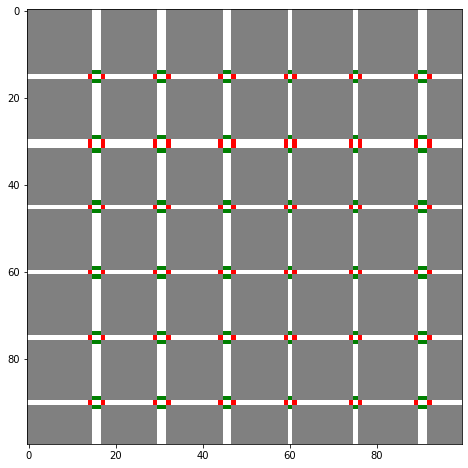

In [5]:
city, random_cars, intersections,\
          vertical_intersections, horizontal_intersections,\
         middle_points,exits,enters, data = initialize(500, 0)
observe(city)


In [6]:
def turn_state(config):
    """
    The CA grid contains objects not numbers so this function will vectorize the grid (turn each object into its CA value)
    """
    vectorized_x = np.vectorize(lambda obj: obj.cell_value)
    
    view_grid = vectorized_x(config).astype(int)
    return view_grid

In [7]:
# getting the coordinates of the intersections at the main street and local streets
vertical_intersections_main = [i for i in vertical_intersections if i[1]==90 or i[1]==91 ]
horizontal_intersections_main = [i for i in horizontal_intersections if i[1]==89 or i[1]==92 ]

vertical_intersections_local = [i for i in vertical_intersections if i[1]!=90 and i[1]!=91 ]
horizontal_intersections_local = [i for i in horizontal_intersections if i[1]!=89 and i[1]!=92 ]

# the cells where we add sensors
sensors_cells = [[15,93],[15,94], [30,93],[30,94], [31,87],[31,88], [45,93],[45,94], [60,87],[60,88],
                 [75, 93],[75,94], [90,87], [90,88]]

In [8]:
# adding the cells at each intersection together (so that all cells of one intersection can have the same stop
# sign queue)

current_r, current_c = 0,0
intersections_cirlces = []
intersections_borders = [i for i in intersections if i not in middle_points]
ns = intersections_borders[:32] +intersections_borders[76:]
for r, c in ns:
    if r - current_r > 10 or c - current_c > 10:
        intersections_cirlces.append([])
    intersections_cirlces[-1].append([r, c])
    current_r, current_c = r, c

cells = [[[29, 15], [32, 15], [30, 14], [31, 14],
 [29, 16], [32, 16], [30, 17], [31, 17]],
 [[29, 30], [32, 30], [30, 29], [31, 29],
 [29, 31], [32, 31], [30, 32], [31, 32]],
 [[29, 45], [32, 45], [30, 44], [31, 44],
 [29, 46], [32, 46], [30, 47], [31, 47]],
 [[29, 60], [32, 60], [30, 59], [31, 59], [30, 61], [31, 61]],
 [[29, 75], [32, 75], [30, 76], [31, 76], [30, 74], [31, 74]],
 [[29, 90], [32, 90], [30, 89], [31, 89],
 [29, 91], [32, 91], [30, 92], [31, 92]]]
        
intersections_cirlces = intersections_cirlces[:6]+cells + intersections_cirlces[6:]   

In [9]:
class sim:
    """
    A class for the main simulation of the three strategies 
    """
    def __init__(self):
        self.flow_rate_counter = 0 # count the number of cars that exit the grid
        
    def run_strategy_1(self, steps, light_duration, record_states = False):
        """
        An implementation of strategy 1: the syncronized traffic lights
        Inputs:
        steps: total number of steps to run
        light_duration: how long before changing the traffic light
        record_states: a paramter to decide whether to record all states for the animation
        """
       
        for time_step in range(steps):

            [i.move(city, time_step) for i in random_cars]

            # changing the traffic lights (syncronized) 
            if time_step % light_duration ==0: 
                [city[row, column].change() for row, column in vertical_intersections]
                [city[row, column].change() for row, column in horizontal_intersections]

                
            # adding cars to the streets overtime using the data collected and the exponential distribution    
            for ind, street in enumerate(data):

                if data[street][1]:
                    time = data[street][1][0]
                    if time_step >= time:
                        r, c = enters[ind]
                        if city[r, c].cell_value == 0:
                            new_car = Car([r, c], random.randint(1, 5))
                            city[r, c].fill_car(new_car)
                            random_cars.append(new_car)
                            data[street][1].pop(0)
            if record_states:
                states.append(turn_state(city))
                
    def run_strategy_2(self, steps,  record_states = False):
        """
        A function to implement strategy 2: traffic lights with sensors around main roads
        """
       
        main_red = False # if main road traffic is red
        for time_step in range(steps):

            [i.move(city, time_step) for i in random_cars]

            # change the traffic lights for the local streets
            if time_step % 35 ==0:
                [city[row, column].change() for row, column in vertical_intersections_local]
                [city[row, column].change() for row, column in horizontal_intersections_local]


            # change the traffic lights for the main road if all sensors are triggered    
            if sum([city[r, c].cell_value for r, c in sensors_cells]) >=14:
                [city[row, column].change() for row, column in vertical_intersections_main]
                [city[row, column].change() for row, column in horizontal_intersections_main]
                main_red = True
                main_change = time_step+25

            # put the traffic lights back to green for the main road
            if main_red and time_step >= main_change:
                [city[row, column].change() for row, column in vertical_intersections_main]
                [city[row, column].change() for row, column in horizontal_intersections_main]
                main_red = False

            # adding cars using the expon dist and data
            for ind, street in enumerate(data):

                if data[street][1]:
                    time = data[street][1][0]
                    if time_step >= time:
                        r, c = enters[ind]
                        if city[r, c].cell_value == 0:
                            new_car = Car([r, c], random.randint(1, 5))
                            city[r, c].fill_car(new_car)
                            random_cars.append(new_car)
                            data[street][1].pop(0)

            if record_states:
                states.append(turn_state(city))

                
    def run_strategy_3(self, time_steps, record_states = False):
        """
        a function that implements strategy 3: stop signs instead of traffic lights
        """
        
        # adding one queue to all cells of each intersection
        for i in intersections_cirlces:
            aq = Q()
            for r, c in i:
                stp_sgn = stop_sign()
                city[r, c] = stp_sgn 
                city[r, c].queue = aq.q

        
        for time_step in range(time_steps):
            
            [i.move(city,time_step) for i in random_cars]

            # adding cars using the expon dist and data
            for ind, street in enumerate(data):
                if data[street][1]:
                    time = data[street][1][0]
                    if time_step >= time:
                        r, c = enters[ind]
                        if city[r, c].cell_value == 0:
                            new_car = Car([r, c], random.randint(1, 5))
                            city[r, c].fill_car(new_car)
                            random_cars.append(new_car)
                            data[street][1].pop(0)


            if record_states:
                states.append(turn_state(city))
        

# Animation
When running the animation, make sure that seaborn is not set because it deforms the shape of the grid

In [10]:
def build_animation(states, save_name):
    """
    A function that makes a very nice animation that can be used to debug the code or to 
    enjoy watching the mini city model
    
    Source: https://stackoverflow.com/questions/17212722/matplotlib-imshow-how-to-animate
    """
    
    fps = 5
    nSeconds = len(states)// fps

    # First set up the figure, the axis, and the plot element we want to animate
    fig = plt.figure( figsize=(8,8) )

    a = states[0]



    colors = ['white', 'gray', 'black',  'green','red' , 'blue', 'orange']
    bounds = [ 0,1,2,3,4, 5, 6]

    cmap = mpl.colors.ListedColormap(colors)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    pylab.cla()
    im = pylab.imshow(a, interpolation='none', cmap=cmap, norm=norm)


    def animate_func(i):
        if i % fps == 0:
            print( '.', end ='' )

        im.set_array(states[i])
        return [im]

    anim = animation.FuncAnimation(
                                   fig, 
                                   animate_func, 
                                   frames = nSeconds * fps,
                                   interval = 1000 / fps, # in ms
                                   )

    anim.save(save_name, fps=fps, extra_args=['-vcodec', 'libx264'])

    print('Done!')


## Strategy 1

.............................................................................................................................................................................................................................................................................................................Done!


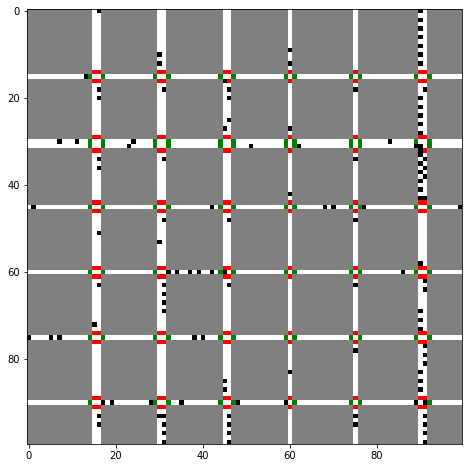

In [11]:
time_steps = 1500

states = []
city, random_cars, intersections,\
              vertical_intersections, horizontal_intersections,\
             middle_points,exits,enters, data = initialize(time_steps, .01)

my_sim = sim()
my_sim.run_strategy_1(time_steps, 35, True)
build_animation(states, 'try_1.mp4')

In [12]:
from IPython.display import Video
Video("try_1.mp4")

## Strategy 2

.............................................................................................................................................................................................................................................................................................................Done!


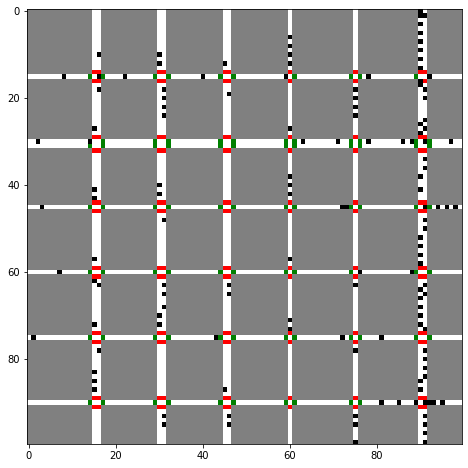

In [13]:
time_steps = 1500

states = []
city, random_cars, intersections,\
              vertical_intersections, horizontal_intersections,\
             middle_points,exits,enters, data = initialize(time_steps, .01)

my_sim = sim()
my_sim.run_strategy_2(time_steps, True)
build_animation(states, 'try_2.mp4')

In [14]:
from IPython.display import Video
Video("try_2.mp4")

## Strategy 3

.............................................................................................................................................................................................................................................................................................................Done!


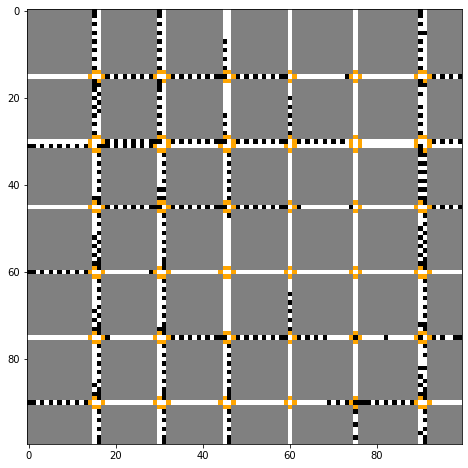

In [15]:
time_steps = 1500

states = []
city, random_cars, intersections,\
              vertical_intersections, horizontal_intersections,\
             middle_points,exits,enters, data = initialize(time_steps, .01)

my_sim = sim()
my_sim.run_strategy_3(time_steps, True)
build_animation(states, 'try_3.mp4')

In [16]:
from IPython.display import Video
Video("try_3.mp4")

# Analysis

In [27]:
# running strategy 1 50 times and collecting the flow rate at each time
strategy_1 = []
time_steps = 500
light_duration = 25
for i in range(60):
    
    city, random_cars, intersections,\
              vertical_intersections, horizontal_intersections,\
             middle_points,exits,enters, data = initialize(time_steps, 0.1)

    my_sim = sim()
    my_sim.run_strategy_1(steps=time_steps, light_duration=light_duration)
    strategy_1.append(my_sim.flow_rate_counter/time_steps)

In [28]:
# running strategy 2 50 times and collecting the flow rate at each time

strategy_2 = []
time_steps = 500
for i in range(60):
    
    city, random_cars, intersections,\
              vertical_intersections, horizontal_intersections,\
             middle_points,exits,enters, data = initialize(time_steps, 0.1)

    my_sim = sim()
    my_sim.run_strategy_2(time_steps)
    strategy_2.append(my_sim.flow_rate_counter/time_steps)

In [29]:
# running strategy 3 50 times and collecting the flow rate at each time

states = []

strategy_3 = []
time_steps = 500
for i in range(60):
    
    city, random_cars, intersections,\
              vertical_intersections, horizontal_intersections,\
             middle_points,exits,enters, data = initialize(time_steps, 0.1)

    my_sim = sim()
    my_sim.run_strategy_3(time_steps)
    strategy_3.append(my_sim.flow_rate_counter/time_steps)

In [30]:
print(np.quantile(strategy_1, 0.025),np.mean(strategy_1),np.quantile(strategy_1, 0.975))

1.4655 1.5367333333333333 1.63335


In [31]:
print(np.quantile(strategy_2, 0.025),np.mean(strategy_2),np.quantile(strategy_2, 0.975))

1.4876 1.5692 1.6353499999999999


In [32]:
print(np.quantile(strategy_3, 0.025),np.mean(strategy_3),np.quantile(strategy_3, 0.975))

1.00085 1.077533333333333 1.1562999999999999


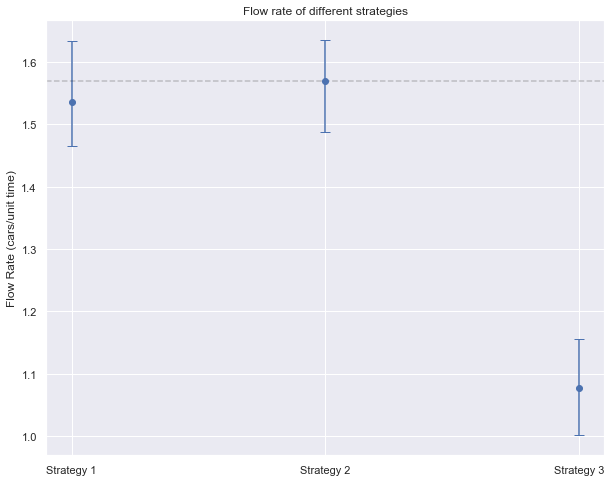

In [60]:
sns.set()
x = ["Strategy 1", "Strategy 2", "Strategy 3"]
averages = [strategy_1, strategy_2, strategy_3]
averages_ = [np.mean(i) for i in averages] 
lowers = [np.percentile(i, [2.5 ,97.5 ])[0] for i in averages] # lower bound 95% conf interval
uppers = [np.percentile(i, [2.5 ,97.5 ])[1] for i in averages] # upper bound 95% conf interval
# Because I'm using errorbars to show the conf intervals, the following will make sure that the interval
# is plotted correctly. I'm doing this because matplot errorbars subtract the mean from the errors 
lower = np.array(lowers)*(-1)+ np.array(averages_) 
upper = np.array(uppers) - np.array(averages_)
errors = np.array([lower, upper])

plt.figure(figsize=(10,8))
plt.errorbar(x, averages_, yerr=errors, fmt='o', capsize=5)
plt.axhline(averages_[1], linestyle='--', alpha = 0.2, color = 'black')
plt.ylabel("Flow Rate (cars/unit time)")
plt.title("Flow rate of different strategies")
plt.show()

In [24]:

#                  **** this cell takes about 30 mins to run *****

# Running strategy 1 for different traffic light durations

switch_times = np.arange(5, 100, 10)
time_steps = 500

flow_rate_mean = []
flow_rate_lists =[]
for switch_time in switch_times:
    flow_rate_averager = []
    for i in range(100):
        city, random_cars, intersections,\
          vertical_intersections, horizontal_intersections,\
         middle_points,exits,enters, data = initialize(time_steps, .01)
        
      
        my_sim = sim()
        my_sim.run_strategy_1(time_steps, switch_time)
        
                
                
                
        fr = my_sim.flow_rate_counter
        flow_rate_averager.append(fr/time_steps)
    print(f"switch time {switch_time} is done")  
    flow_rate_lists.append(flow_rate_averager)
    

switch time 5 is done
switch time 15 is done
switch time 25 is done
switch time 35 is done
switch time 45 is done
switch time 55 is done
switch time 65 is done
switch time 75 is done
switch time 85 is done
switch time 95 is done


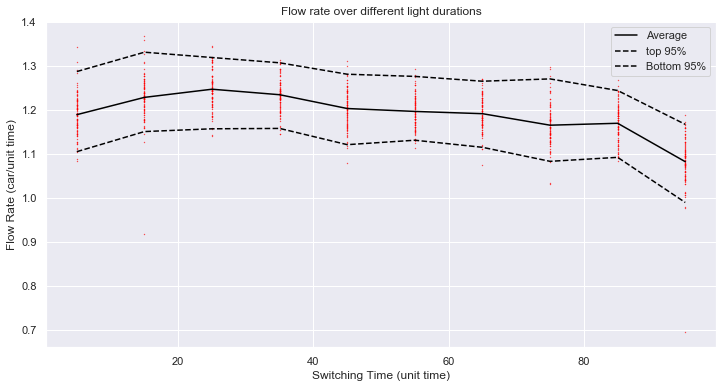

In [55]:
switch_times = np.arange(5, 100, 10)


flow_rate_mean = [np.mean(i)  for i in flow_rate_lists]

top = [np.quantile(i, 0.975) for i in flow_rate_lists ]
Bottom = [np.quantile(i, 0.025) for i in flow_rate_lists ]

points_flow = np.concatenate(flow_rate_lists)
switch_times_points = np.concatenate([[switch_times[i]]*len(flow_rate_lists[i]) for i in range(len(flow_rate_lists)) ])

plt.figure(figsize=(12, 6))

plt.plot(switch_times,flow_rate_mean, label = 'Average', color = 'black' )
plt.plot(switch_times,top,  'k--', color = 'black', label = 'top 95%')
plt.plot(switch_times,Bottom,  'k--' , color = 'black', label = 'Bottom 95%')

plt.scatter(switch_times_points,points_flow, color = 'red', s = .1 )

plt.title("Flow rate over different light durations")
plt.xlabel("Switching Time (unit time)")
plt.ylabel("Flow Rate (car/unit time)")
plt.legend()
plt.show()

In [49]:
max_ind = np.argmax(flow_rate_mean)
print(Bottom[max_ind], flow_rate_mean[max_ind],top[max_ind])

1.15695 1.24698 1.31905
